In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.4.1


In [ ]:
pip install --user tensorflow-addons==0.8.3

     |████████████████████████████████| 1.0MB 8.8MB/s 


In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 7

In [ ]:
TRAIN_PATH = '/content/drive/MyDrive/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
TEST_PATH = '/content/drive/MyDrive/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'

df=pd.read_csv('/content/drive/MyDrive/Chest_xray_Corona_Metadata.csv')

df.head()

,Unnamed: 0,image_name,Label,Dataset_type
0,0,IM-0128-0001.jpeg,Normal,TRAIN
1,1,IM-0127-0001.jpeg,Normal,TRAIN
2,2,IM-0125-0001.jpeg,Normal,TRAIN
3,3,IM-0122-0001.jpeg,Normal,TRAIN
4,4,IM-0119-0001.jpeg,Normal,TRAIN


In [ ]:
df=df.drop(labels=['Unnamed: 0'], axis=1)

In [ ]:
df.head()

,image_name,Label,Dataset_type
0,IM-0128-0001.jpeg,Normal,TRAIN
1,IM-0127-0001.jpeg,Normal,TRAIN
2,IM-0125-0001.jpeg,Normal,TRAIN
3,IM-0122-0001.jpeg,Normal,TRAIN
4,IM-0119-0001.jpeg,Normal,TRAIN


In [ ]:
traindf=df[df['Dataset_type']=='TRAIN']
testdf=df[df['Dataset_type']=='TEST']

In [ ]:
df['Label'].value_counts()

Pnemonia    4334
Normal      1576
Name: Label, dtype: int64

In [ ]:
classes = {0 : "Pnemonia",1 : "Normal"}

In [ ]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          validation_split = 0.2,
                                                          preprocessing_function = data_augment)



In [ ]:
train_gen = datagen.flow_from_dataframe(dataframe = traindf,directory = TRAIN_PATH,
                                        x_col = 'image_name',
                                        y_col = 'Label',
                                        subset = 'training',
                                        batch_size = BATCH_SIZE,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        class_mode = 'categorical',
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE))

Found 4229 validated image filenames belonging to 2 classes.


In [ ]:
valid_gen = datagen.flow_from_dataframe(dataframe = testdf,
                                        directory = TEST_PATH,
                                        x_col = 'image_name',
                                        y_col = 'Label',
                                        subset = 'validation',
                                        batch_size = BATCH_SIZE,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = False,
                                        class_mode = 'categorical',
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE))

Found 124 validated image filenames belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<function matplotlib.pyplot.show>

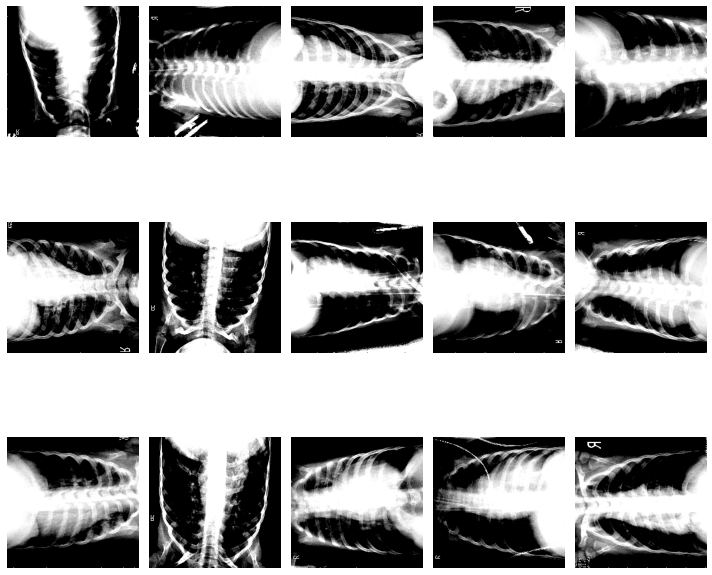

In [ ]:
images = [train_gen[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.axis('off')

plt.tight_layout()
plt.show

In [ ]:
pip install vit-keras

In [ ]:
from vit_keras import vit

In [ ]:
vit_model = vit.vit_b16(image_size = IMAGE_SIZE,activation = 'softmax',pretrained = True,include_top = False,
pretrained_top = False,classes = 2)

347504640/347502902 [==============================] - 6s 0us/step


In [ ]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.rrelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, 'softmax')
    ],name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b16 (Functional)         (None, 768)               85798656  
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 768)               3072      
_________________________________________________________________
dense (Dense)                (None, 11)                8459      
_________________________________________________________________
batch_normalization_1 (Batch (None, 11)                44        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 24        
Total params: 85,810,255
Trainable params: 85,808,697
Non-trainable params: 1,558
________________________________

In [ ]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), metrics = ['accuracy'])

In [ ]:
STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',factor = 0.2,patience = 2,
verbose = 1,min_delta = 1e-4,min_lr = 1e-6,mode = 'max')

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',min_delta = 1e-4,patience = 5,
mode = 'max',restore_best_weights = True,verbose = 1)

In [ ]:
callbacks = [earlystopping, reduce_lr]

In [23]:
model.fit(x = train_gen,steps_per_epoch = STEP_SIZE_TRAIN,validation_data = valid_gen,validation_steps = STEP_SIZE_VALID,epochs = EPOCHS,
callbacks = callbacks)

Epoch 1/7
264/264 [==============================] - 1589s 6s/step - loss: 0.7918 - accuracy: 0.5591 - val_loss: 0.4067 - val_accuracy: 1.0000
Epoch 2/7
264/264 [==============================] - 244s 922ms/step - loss: 0.6416 - accuracy: 0.7141 - val_loss: 0.5406 - val_accuracy: 0.9643
Epoch 3/7
264/264 [==============================] - 242s 917ms/step - loss: 0.5900 - accuracy: 0.8305 - val_loss: 0.6597 - val_accuracy: 0.7589

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 4/7
264/264 [==============================] - 241s 914ms/step - loss: 0.5455 - accuracy: 0.8854 - val_loss: 0.7539 - val_accuracy: 0.6250
Epoch 5/7
264/264 [==============================] - 241s 914ms/step - loss: 0.5251 - accuracy: 0.9285 - val_loss: 0.8377 - val_accuracy: 0.7054

Epoch 00005: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
Epoch 6/7
264/264 [==============================] - 242s 916ms/step - loss: 0.5128 - accuracy: 0.9436 - val_loss:

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       124
           1       0.00      0.00      0.00         0

    accuracy                           0.97       124
   macro avg       0.50      0.48      0.49       124
weighted avg       1.00      0.97      0.98       124



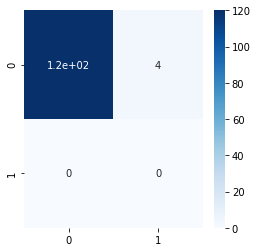

In [25]:
predicted_classes = np.argmax(model.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())  

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (4, 4))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))